In [841]:
#%%
import os
from PIL import Image
import pickle
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted


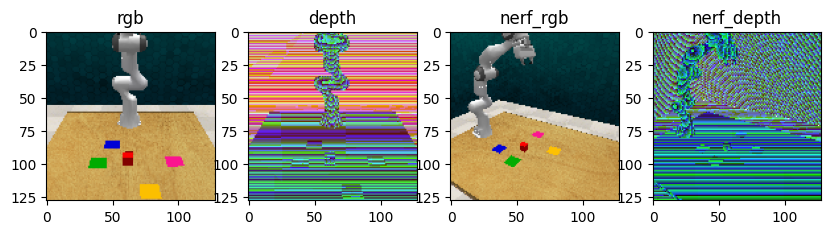

In [842]:
task = 'slide_block_to_color_target'
data_dir  = f'../data/train_data_50view/{task}/all_variations/episodes/'
episode = 'episode0'
episodes = os.listdir(data_dir)

step = 0
cam_view = 20
episode_dir = f'{data_dir}/{episode}/'

front_rgb_dir = episode_dir + 'front_rgb/'
front_rgb = natsorted(os.listdir(front_rgb_dir))

front_depth_dir = episode_dir + 'front_depth/'
front_depth = natsorted(os.listdir(front_depth_dir))

nerf_data_dir = episode_dir + 'nerf_data/' 
# num_nerf_data = len(os.listdir(nerf_data_dir))
num_nerf_data = natsorted(os.listdir(nerf_data_dir))

f_rgb = Image.open(front_rgb_dir+front_rgb[step])
f_rgb = np.array(f_rgb)

f_depth = Image.open(front_depth_dir+front_depth[step])
# print(np.array(f_depth).shape)
f_depth = np.array(f_depth)

nerf_rgb = Image.open(nerf_data_dir+num_nerf_data[step]+f'/images/{cam_view}.png')
nerf_rgb = np.array(nerf_rgb)

nerf_camera_dir = nerf_data_dir + num_nerf_data[step]+f'/poses/{cam_view}.txt'

nerf_depth = Image.open(nerf_data_dir+num_nerf_data[step]+f'/depths/{cam_view}.png')
nerf_depth = np.array(nerf_depth)

fig, ax = plt.subplots(1,4,figsize=(10,7))
ax[0].set_title('rgb')
ax[0].imshow(f_rgb)
ax[1].set_title('depth')
ax[1].imshow(f_depth)
ax[2].set_title('nerf_rgb')
ax[2].imshow(nerf_rgb)
ax[3].set_title('nerf_depth')
ax[3].imshow(nerf_depth)
plt.show()

# f_mask
    

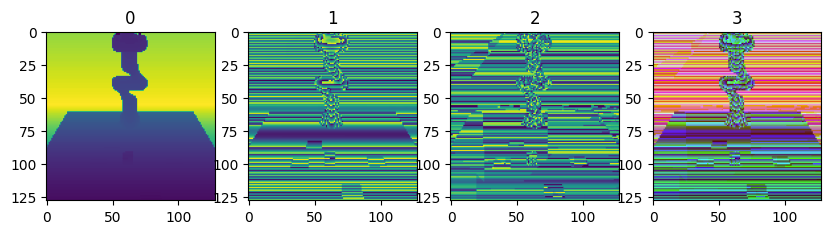

In [843]:
fig, ax = plt.subplots(1,4,figsize=(10,7))
ax[0].set_title('0')
ax[0].imshow(f_depth[...,0])
ax[1].set_title('1')
ax[1].imshow(f_depth[...,1])
ax[2].set_title('2')
ax[2].imshow(f_depth[...,2])
ax[3].set_title('3')
ax[3].imshow(f_depth)
plt.show()

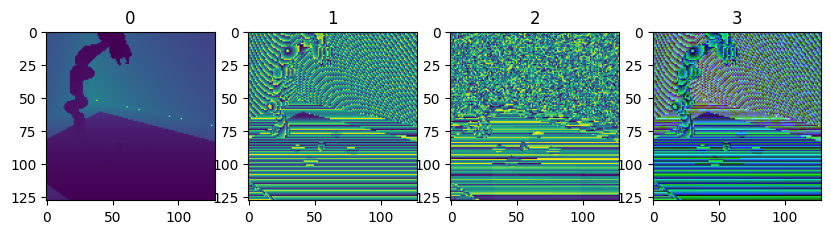

In [844]:
fig, ax = plt.subplots(1,4,figsize=(10,7))
ax[0].set_title('0')
ax[0].imshow(nerf_depth[...,0])
ax[1].set_title('1')
ax[1].imshow(nerf_depth[...,1])
ax[2].set_title('2')
ax[2].imshow(nerf_depth[...,2])
ax[3].set_title('3')
ax[3].imshow(nerf_depth)
plt.show()


In [845]:
nerf_depth

array([[[ 79, 196, 187],
        [ 80,  90, 197],
        [ 80, 243,   6],
        ...,
        [ 68,  22, 135],
        [ 67, 215, 245],
        [ 67, 153, 214]],

       [[ 79, 233, 191],
        [ 80, 128,  85],
        [ 81,  25,  36],
        ...,
        [ 68,  67, 240],
        [ 68,   5,  82],
        [ 67, 198, 223]],

       [[ 80,  14, 231],
        [ 80, 166,   8],
        [ 81,  63, 103],
        ...,
        [ 68, 113, 221],
        [ 68,  50, 163],
        [ 67, 243, 222]],

       ...,

       [[ 43, 176,  76],
        [ 43, 176,  76],
        [ 43, 176,  47],
        ...,
        [ 22, 212,  39],
        [ 22, 212,  39],
        [ 22, 212,  39]],

       [[ 43,  77,  89],
        [ 43,  77,  89],
        [ 43,  77, 118],
        ...,
        [ 22, 160,  38],
        [ 22, 160,  38],
        [ 22, 160,  38]],

       [[ 42, 236,  32],
        [ 42, 236,  32],
        [ 42, 236,  60],
        ...,
        [ 22, 109,  21],
        [ 22, 109,  21],
        [ 22, 109,  21]]

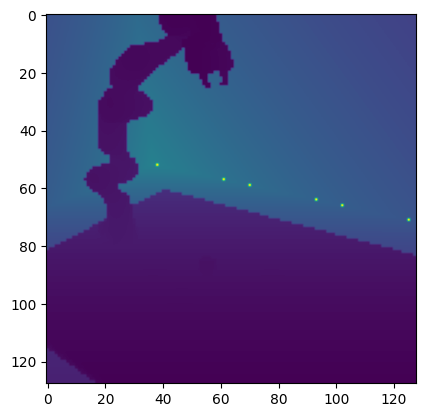

In [846]:
depth_combined = nerf_depth[:, :, 0] * (256**2) + nerf_depth[:, :, 1] * 256 + nerf_depth[:, :, 2]

# Normalize depth to an appropriate range, if needed
depth_combined = depth_combined.astype(np.float32) / np.max(depth_combined)
plt.imshow(depth_combined)

In [847]:

def pointcloud_from_depth_and_camera_params(
        depth: np.ndarray, extrinsics: np.ndarray,
        intrinsics: np.ndarray) -> np.ndarray:
    """Converts depth (in meters) to point cloud in word frame.
    :return: A numpy array of size (width, height, 3)
    """
    # make sure intrinsic is non-negative
    upc = _create_uniform_pixel_coords_image(depth.shape)  
    # print(upc)
    pc = upc * np.expand_dims(depth, -1)
    C = np.expand_dims(extrinsics[:3, 3], 0).T
    R = extrinsics[:3, :3]
    R_inv = R.T  # inverse of rot matrix is transpose
    R_inv_C = np.matmul(R_inv, C)
    extrinsics = np.concatenate((R_inv, -R_inv_C), -1)
    cam_proj_mat = np.matmul(intrinsics, extrinsics)
    cam_proj_mat_homo = np.concatenate(
        [cam_proj_mat, [np.array([0, 0, 0, 1])]])
    cam_proj_mat_inv = np.linalg.inv(cam_proj_mat_homo)[0:3]
    world_coords_homo = np.expand_dims(_pixel_to_world_coords(
        pc, cam_proj_mat_inv), 0)
    world_coords = world_coords_homo[..., :-1][0]
    return world_coords
    
def _create_uniform_pixel_coords_image(resolution: np.ndarray):
    pixel_x_coords = np.reshape(
        np.tile(np.arange(resolution[1]), [resolution[0]]),
        (resolution[0], resolution[1], 1)).astype(np.float32)
    pixel_y_coords = np.reshape(
        np.tile(np.arange(resolution[0]), [resolution[1]]),
        (resolution[1], resolution[0], 1)).astype(np.float32)
    pixel_y_coords = np.transpose(pixel_y_coords, (1, 0, 2))
    uniform_pixel_coords = np.concatenate(
        (pixel_x_coords, pixel_y_coords, np.ones_like(pixel_x_coords)), -1)
    return uniform_pixel_coords

def _transform(coords, trans):
    h, w = coords.shape[:2]
    coords = np.reshape(coords, (h * w, -1))
    coords = np.transpose(coords, (1, 0))
    transformed_coords_vector = np.matmul(trans, coords)
    transformed_coords_vector = np.transpose(
        transformed_coords_vector, (1, 0))
    return np.reshape(transformed_coords_vector,
                      (h, w, -1))
    
def _pixel_to_world_coords(pixel_coords, cam_proj_mat_inv):
    h, w = pixel_coords.shape[:2]
    pixel_coords = np.concatenate(
        [pixel_coords, np.ones((h, w, 1))], -1)
    world_coords = _transform(pixel_coords, cam_proj_mat_inv)
    world_coords_homo = np.concatenate(
        [world_coords, np.ones((h, w, 1))], axis=-1)
    return world_coords_homo

def parse_camera_file(file_path):
    """
    Parse our camera format.

    The format is (*.txt):
    
    4x4 matrix (camera extrinsic)
    space
    3x3 matrix (camera intrinsic)

    focal is extracted from the intrinsc matrix
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    camera_extrinsic = []
    for x in lines[0:4]:
        camera_extrinsic += [float(y) for y in x.split()]
    camera_extrinsic = np.array(camera_extrinsic).reshape(4, 4)

    camera_intrinsic = []
    for x in lines[5:8]:
        camera_intrinsic += [float(y) for y in x.split()]
    camera_intrinsic = np.array(camera_intrinsic).reshape(3, 3)

    focal = camera_intrinsic[0, 0]

    return camera_extrinsic, camera_intrinsic, focal


DEFAULT_RGB_SCALE_FACTOR = 256000.0
DEFAULT_GRAY_SCALE_FACTOR = {np.uint8: 100.0,
                             np.uint16: 1000.0,
                             np.int32: DEFAULT_RGB_SCALE_FACTOR}
DEPTH_SCALE = 2**24 - 1
def image_to_float_array(image, scale_factor=DEPTH_SCALE):
  """Recovers the depth values from an image.

  Reverses the depth to image conversion performed by FloatArrayToRgbImage or
  FloatArrayToGrayImage.

  The image is treated as an array of fixed point depth values.  Each
  value is converted to float and scaled by the inverse of the factor
  that was used to generate the Image object from depth values.  If
  scale_factor is specified, it should be the same value that was
  specified in the original conversion.

  The result of this function should be equal to the original input
  within the precision of the conversion.

  Args:
    image: Depth image output of FloatArrayTo[Format]Image.
    scale_factor: Fixed point scale factor.

  Returns:
    A 2D floating point numpy array representing a depth image.

  """
  image_array = np.array(image)
  image_dtype = image_array.dtype
  image_shape = image_array.shape

  channels = image_shape[2] if len(image_shape) > 2 else 1
  assert 2 <= len(image_shape) <= 3
  if channels == 3:
    # RGB image needs to be converted to 24 bit integer.
    float_array = np.sum(image_array * [65536, 256, 1], axis=2)
    if scale_factor is None:
      scale_factor = DEFAULT_RGB_SCALE_FACTOR
  else:
    if scale_factor is None:
      scale_factor = DEFAULT_GRAY_SCALE_FACTOR[image_dtype.type]
    float_array = image_array.astype(np.float32)
  scaled_array = float_array / scale_factor
  return scaled_array


### depth to point cloud

In [848]:
nerf_camera_dir

'../data/train_data_50view/slide_block_to_color_target/all_variations/episodes//episode0/nerf_data/0/poses/20.txt'

(128, 128)


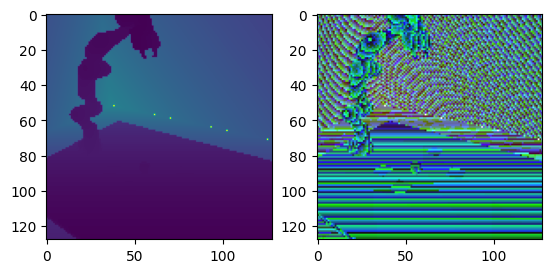

In [849]:
camera_extrinsic, camera_intrinsic, focal = parse_camera_file(nerf_camera_dir)
depth = image_to_float_array(nerf_depth)
print(depth.shape)
plt.subplot(121)
plt.imshow(depth)
plt.subplot(122)
plt.imshow(nerf_depth)


In [850]:
camera_extrinsic

array([[-8.632110e-01, -2.133560e-01, -4.575430e-01,  8.424640e-01],
       [-5.048440e-01,  3.648080e-01,  7.823350e-01, -8.847900e-01],
       [-1.000000e-06,  9.063080e-01, -4.226180e-01,  1.579999e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.988587692527136..9.48627894983929].


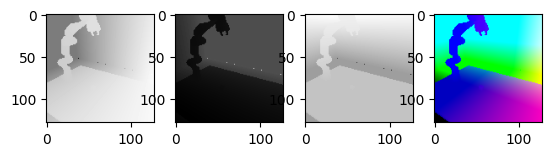

In [851]:

# r_90 = np.array([[-1, 0, 0], 
#                 [0, -1, 0], 
#                 [0, 0, -1]])
# camera_extrinsic[:3,:3] = np.matmul(camera_extrinsic[:3,:3], r_90)
# camera_extrinsic = sim_to_colmap(camera_extrinsic)
pcl = pointcloud_from_depth_and_camera_params(depth*10,camera_extrinsic,camera_intrinsic)
plt.subplot(141)
plt.imshow(pcl[...,0],cmap='gray')
plt.subplot(142)
plt.imshow(pcl[...,1],cmap='gray')
plt.subplot(143)
plt.imshow(pcl[...,2],cmap='gray')
plt.subplot(144)
plt.imshow(pcl)

(-0.1, 1.5)

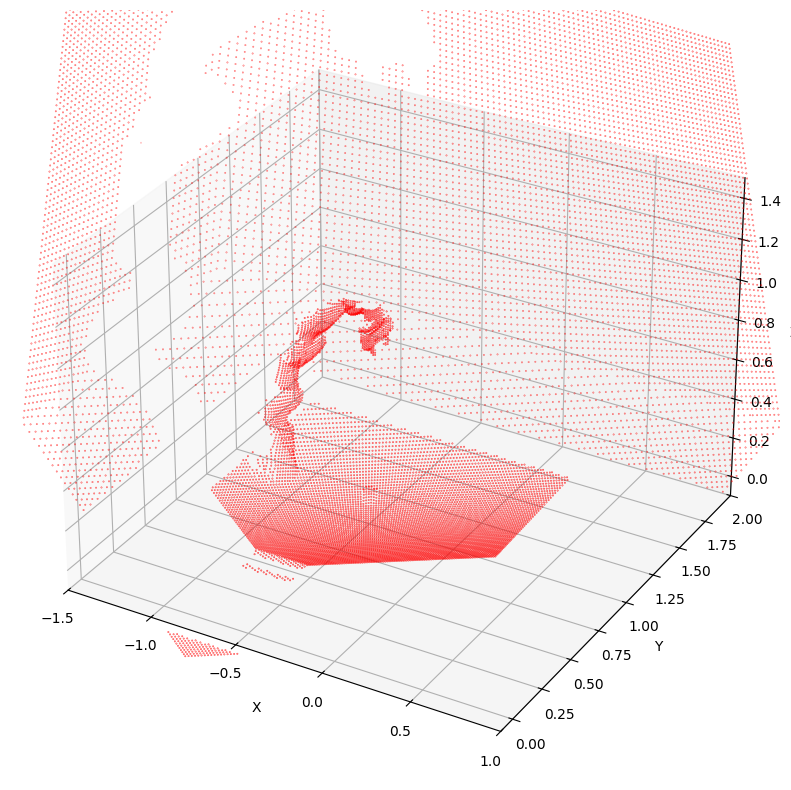

In [852]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pcl[...,0], pcl[...,1], pcl[...,2], color='r', s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-1.5, 1])
ax.set_ylim([-0.1, 2])
ax.set_zlim([-0.1, 1.5])

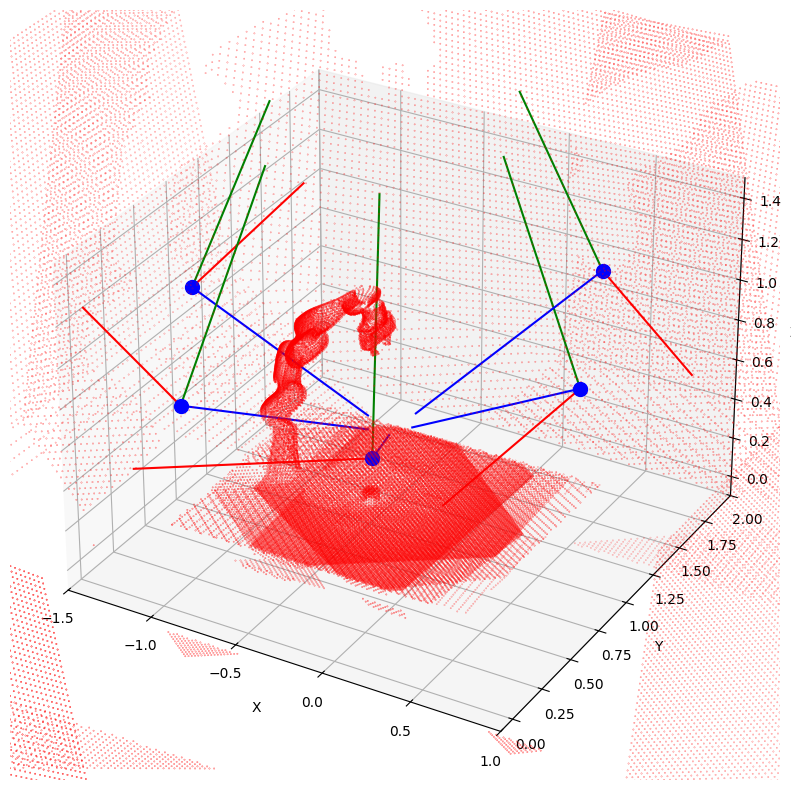

In [853]:
import numpy as np
import matplotlib.pyplot as plt


def plot_camera(ax, R, t, scale=1.0, color='b'):
    # Camera center
    ax.scatter(t[0], t[1], t[2], color=color, s=100)
    
    # Camera axes
    cam_axes = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, scale]])
    cam_axes = R @ cam_axes.T + t.reshape(3, 1)
    # print(cam_axes)
    
    ax.plot([t[0], cam_axes[0, 0]], [t[1], cam_axes[1, 0]], [t[2], cam_axes[2, 0]], color='r')
    ax.plot([t[0], cam_axes[0, 1]], [t[1], cam_axes[1, 1]], [t[2], cam_axes[2, 1]], color='g')
    ax.plot([t[0], cam_axes[0, 2]], [t[1], cam_axes[1, 2]], [t[2], cam_axes[2, 2]], color='b')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Example extrinsic parameters
# R = np.eye(3)  # Rotation matrix
# t = np.array([0, 0, 0])  # Translation vector
for i in range(0,50,10):
    nerf_camera_dir = nerf_data_dir + num_nerf_data[step]+f'/poses/{i}.txt'
    camera_extrinsic, camera_intrinsic, focal = parse_camera_file(nerf_camera_dir)
    
    nerf_depth = Image.open(nerf_data_dir+num_nerf_data[step]+f'/depths/{i}.png')
    nerf_depth = np.array(nerf_depth)
    depth = image_to_float_array(nerf_depth)
    camera_extrinsic, camera_intrinsic, focal = parse_camera_file(nerf_camera_dir)
    pcl = pointcloud_from_depth_and_camera_params(depth*10,camera_extrinsic,camera_intrinsic)
    ax.scatter(pcl[...,0], pcl[...,1], pcl[...,2], color='r', s=0.05)
    
    R = camera_extrinsic[:3,:3]
    t = camera_extrinsic[:3,3]
    plot_camera(ax, R, t)
    
    
ax.scatter(pcl[...,0], pcl[...,1], pcl[...,2], color='r', s=0.05)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-1.5, 1])
ax.set_ylim([-0.1, 2])
ax.set_zlim([-0.1, 1.5])
plt.show()


[[-9.983400e-02  4.205070e-01  9.017800e-01 -6.948790e-01]
 [ 9.950040e-01  4.219200e-02  9.048000e-02 -1.023290e-01]
 [-1.000000e-06  9.063080e-01 -4.226180e-01  1.579999e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
[[-9.98338438e-02  4.20506499e-01  9.01780103e-01 -6.94879000e-01]
 [ 9.95004229e-01  4.21925461e-02  9.04799300e-02 -1.02329000e-01]
 [-4.28399988e-07  9.06307663e-01 -4.22618332e-01  1.57999900e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-5.646430e-01  3.488010e-01  7.480080e-01 -5.209680e-01]
 [ 8.253360e-01  2.386290e-01  5.117400e-01 -5.787580e-01]
 [-1.000000e-06  9.063080e-01 -4.226180e-01  1.579999e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
[[-5.64642648e-01  3.48801141e-01  7.48008436e-01 -5.20968000e-01]
 [ 8.25334750e-01  2.38628909e-01  5.11739831e-01 -5.78758000e-01]
 [-9.77291449e-07  9.06307828e-01 -4.22617978e-01  1.57999900e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.000

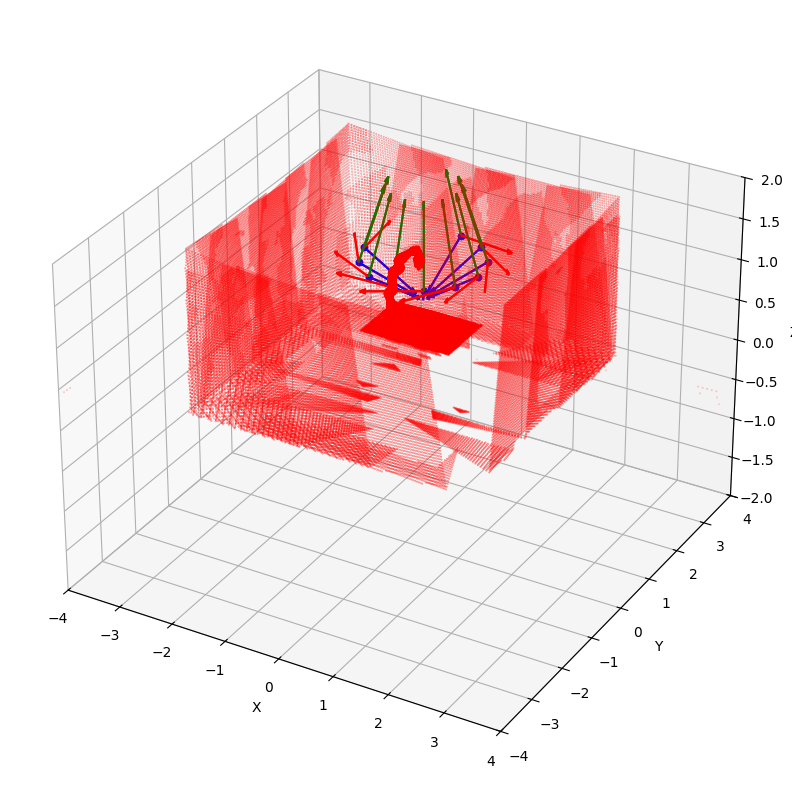

In [892]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
def sim_to_colmap(extrinsics):
    R = extrinsics[:3, :3]
    t = extrinsics[:3, 3]

    # Invert the rotation matrix (transpose, since it's orthogonal)
    R_inv = R.T
    # R_inv = np.linalg.inv(R)
    # print(R_inv)
    # print(R.T)
    # # Compute the new translation vector
    # # t_inv = -np.dot(R_inv, t)
    # print(t)
    R_flip = Rotation.from_euler('z', 180, degrees=True).as_matrix()
    R_inv = R_flip @ R_inv
    
    t_inv = -R_inv @ t
    # print('t_inv')
    # print(t_inv)
    # print('RT')
    # print(-R.T@t)



    # Form the inverted transformation matrix
    extrinsics = np.eye(4)
    # print(extrinsics)
    extrinsics[:3, :3] = R_inv
    extrinsics[:3, 3] = t_inv
    
    return extrinsics



def colmap_to_sim(extr):
    
    extr = np.linalg.inv(extr)
    
    R = extr[:3, :3]
    t = extr[:3, 3]

    R = R.T
    R_flip = Rotation.from_euler('z', 180, degrees=True).as_matrix()
    R = R_flip @ R
    R = R.T
    # t = -R @ t
    
    
    extr = np.eye(4)
    extr[:3, :3] = R
    extr[:3, 3] = t
    
    
    
    return extr


def plot_camera(ax, extrinsics, scale=1.0, c='b',label=None):
    """
    Plots a camera using its extrinsic matrix in 3D space.
    
    Parameters:
    ax (matplotlib.axes._subplots.Axes3DSubplot): The 3D axis to plot on.
    extrinsics (numpy.ndarray): 4x4 extrinsic matrix (rotation and translation).
    scale (float): The scale of the axes representing the camera's orientation.
    label (str): Optional label for the camera.
    """
    # Extract the rotation (3x3) and translation (3x1) from the extrinsics
    R = extrinsics[:3, :3]
    t = extrinsics[:3, 3]
    
    # Camera's origin in the plot (translation vector)
    origin = t
    
    # Plot the camera origin
    ax.scatter(origin[0], origin[1], origin[2], c=c, marker='o', label=label)
    
    # Create basis vectors for the camera's orientation (X, Y, Z axes)
    x_axis = R[:, 0] * scale  # Camera's X-axis
    y_axis = R[:, 1] * scale  # Camera's Y-axis
    z_axis = R[:, 2] * scale  # Camera's Z-axis
    # print(np.dot(x_axis,y_axis),np.dot(x_axis,z_axis), np.dot(y_axis,z_axis))
    
    # Plot camera's axes
    ax.quiver(*origin, *x_axis, color='r', length=scale, arrow_length_ratio=0.1, label='Camera X-axis')
    ax.quiver(*origin, *y_axis, color='g', length=scale, arrow_length_ratio=0.1, label='Camera Y-axis')
    ax.quiver(*origin, *z_axis, color='b', length=scale, arrow_length_ratio=0.1, label='Camera Z-axis')

def transform_pointcloud(points, T):
    """
    Transforms a point cloud using the given transformation matrix.
    
    Parameters:
    points (numpy.ndarray): Nx3 array of 3D points in CoppeliaSim coordinate system
    T (numpy.ndarray): 4x4 transformation matrix (inverted from CoppeliaSim camera-to-world to world-to-camera)
    
    Returns:
    numpy.ndarray: Nx3 array of transformed points in COLMAP coordinate system
    """
    
    points = points.reshape(-1,3)
    # Convert the point cloud to homogeneous coordinates (Nx4)
    num_points = points.shape[0]
    points_homogeneous = np.hstack([points, np.ones((num_points, 1))])
    # print(points.shape)
    # Apply the transformation matrix to each point
    transformed_points_homogeneous = (T @ points_homogeneous.T).T
    # points = (R @ points.T).T
    # points = np.matmul(R,points.T).T
    # print(points.shape)
    # print(transformed_points_homogeneous.shape)
    # Return the transformed points (drop the homogeneous coordinate)
    return transformed_points_homogeneous


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


pcds = []
for i in range(0,50,5):
    nerf_camera_dir = nerf_data_dir + num_nerf_data[step]+f'/poses/{i}.txt'
    camera_extrinsic, camera_intrinsic, focal = parse_camera_file(nerf_camera_dir)
    print(camera_extrinsic)
    plot_camera(ax, camera_extrinsic,c = 'r')
    colmap_camera_extrinsic = sim_to_colmap(camera_extrinsic)

    camera_extrinsic = colmap_to_sim(colmap_camera_extrinsic)
    
    plot_camera(ax, camera_extrinsic)
    print(camera_extrinsic)
    
    euler = Rotation.from_matrix(R).as_euler('xyz', degrees=True)
    # print(euler)
    
    nerf_camera_dir = nerf_data_dir + num_nerf_data[step]+f'/poses/{i}.txt'
    nerf_depth = Image.open(nerf_data_dir+num_nerf_data[step]+f'/depths/{i}.png')
    # nerf_rgb = np.array(Image.open(nerf_data_dir+num_nerf_data[step]+f"/images/{i}.png"))/255
    nerf_depth = np.array(nerf_depth)
    depth = image_to_float_array(nerf_depth)
    near = 0
    far = 10
    depth_m = near + depth * (far - near)
    
    pcd = pointcloud_from_depth_and_camera_params(depth_m,camera_extrinsic,camera_intrinsic)
    # pcd = transform_pointcloud(pcd, colmap_camera_extrinsic)
    pcds.append(pcd)





pcds = np.concatenate(pcds,axis=0)
# pcds = pcds*2.5


ax.scatter(pcds[...,0], pcds[...,1], pcds[...,2], color='r', s=0.05)


# pcl = pointcloud_from_depth_and_camera_params(depth*4.5,camera_extrinsic,camera_intrinsic)
# plt.subplot(141)
# plt.imshow(pcl[...,0],cmap='gray')
# plt.subplot(142)
# plt.imshow(pcl[...,1],cmap='gray')
# plt.subplot(143)
# plt.imshow(pcl[...,2],cmap='gray')
# plt.subplot(144)
# plt.imshow(pcl)
# ax.scatter(pcl[...,0], pcl[...,1], pcl[...,2], color='r', s=0.001)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.set_zlim([-2, 2])
# ax.azim = 90 # x
# ax.elev = 90 # y

plt.show()
# 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.936229496462206..2.851707070696575].


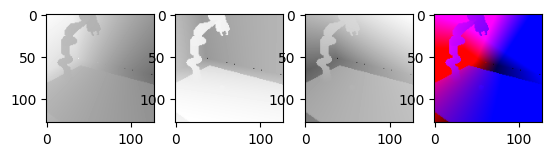

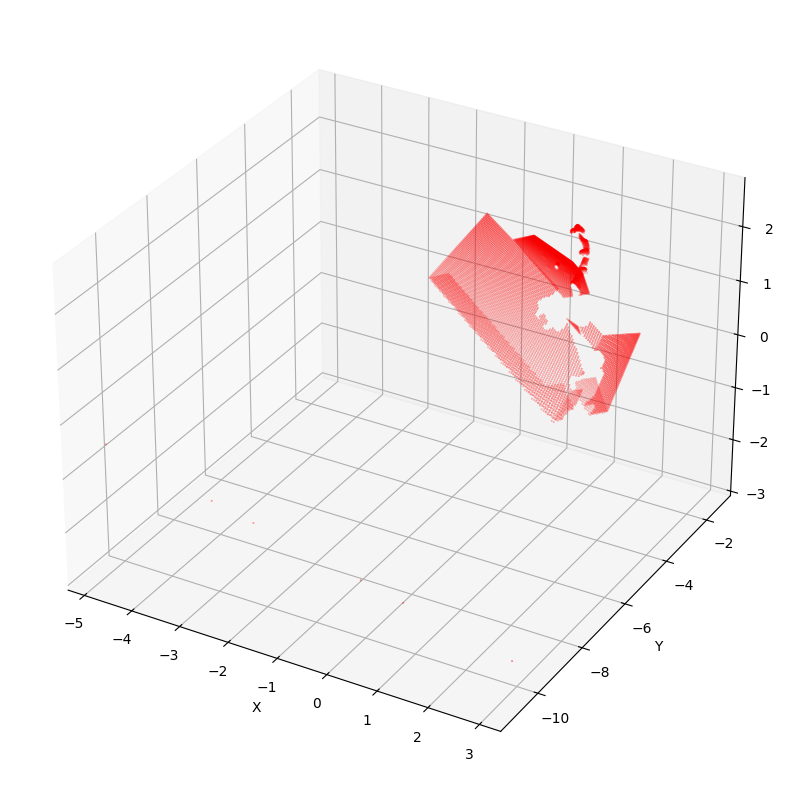

In [866]:
nerf_camera_dir = nerf_data_dir + num_nerf_data[step]+f'/poses/{cam_view}.txt'
camera_extrinsic, camera_intrinsic, focal = parse_camera_file(nerf_camera_dir)
nerf_depth = Image.open(nerf_data_dir+num_nerf_data[step]+f'/depths/{cam_view}.png')
nerf_depth = np.array(nerf_depth)
depth = image_to_float_array(nerf_depth)

camera_extrinsic = sim_to_colmap(camera_extrinsic)
# camera_intrinsic[0,0] *= -1
# camera_intrinsic[1,1] *= -1

pcl = pointcloud_from_depth_and_camera_params(depth*10,camera_extrinsic,camera_intrinsic)
plt.subplot(141)
plt.imshow(pcl[...,0],cmap='gray')
plt.subplot(142)
plt.imshow(pcl[...,1],cmap='gray')
plt.subplot(143)
plt.imshow(pcl[...,2],cmap='gray')
plt.subplot(144)
plt.imshow(pcl)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pcl[...,0], pcl[...,1], pcl[...,2], color='r', s=0.05)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim([-1.5, 1])
# ax.set_ylim([-0.1, 2])
# ax.set_zlim([-0.1, 1.5])
# ax.elev = 0
# ax.azim = 0
# ax.dist = 90
plt.show()

In [867]:
import torch
torch.diag(torch.tensor([1, 1, 1, 1], dtype=torch.float32))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])